In [ ]:

!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
# Install kagglehub if not already installed
!pip install kagglehub
# Download the dataset
import kagglehub
path = kagglehub.dataset_download("trnquanghuyn/casia-b")
print("Path to dataset files:", path)
# Let's check what's in the downloaded directory
!ls -la {path}

In [ ]:
%pip install tensorflow


Starting Gait Recognition System with K-Fold Cross Validation
Loading and preprocessing data for K-Fold CV...


Processing unknown subjects sequences: 100%|██████████| 550/550 [00:07<00:00, 70.02it/s]


Loaded known subjects: X_all_known shape: (10336, 16, 64, 44), y_all_known shape: (10336,)
Loaded unknown subjects: X_all_unknown shape: (2804, 16, 64, 44)

--- Fold 1/5 ---
Training model...
Epoch 1/10
1034/1034 ━━━━━━━━━━━━━━━━━━━━ 464s 415ms/step - accuracy: 0.0848 - loss: 2.9090 - val_accuracy: 0.3172 - val_loss: 2.0422 - learning_rate: 5.0000e-04
Epoch 2/10
1034/1034 ━━━━━━━━━━━━━━━━━━━━ 424s 410ms/step - accuracy: 0.3497 - loss: 1.9637 - val_accuracy: 0.6983 - val_loss: 1.0934 - learning_rate: 5.0000e-04
Epoch 3/10
1034/1034 ━━━━━━━━━━━━━━━━━━━━ 412s 398ms/step - accuracy: 0.6345 - loss: 1.1368 - val_accuracy: 0.7916 - val_loss: 0.6833 - learning_rate: 5.0000e-04
Epoch 4/10
1034/1034 ━━━━━━━━━━━━━━━━━━━━ 384s 371ms/step - accuracy: 0.7995 - loss: 0.6574 - val_accuracy: 0.8951 - val_loss: 0.3487 - learning_rate: 5.0000e-04
Epoch 5/10
1034/1034 ━━━━━━━━━━━━━━━━━━━━ 374s 362ms/step - accuracy: 0.8897 - loss: 0.4000 - val_accuracy: 0.9110 - val_loss: 0.2905 - learning_rate: 5.0000e-0

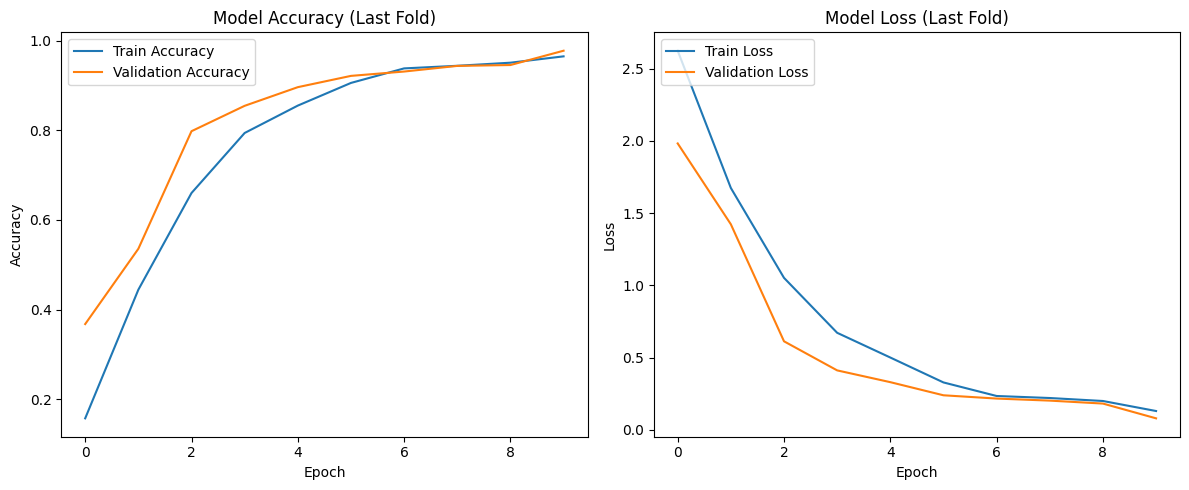


Training and K-Fold evaluation complete!


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.manifold import TSNE
from tensorflow.keras.utils import to_categorical
import seaborn as sns
from tqdm import tqdm
from glob import glob
import warnings
import pickle
from collections import defaultdict
import gc # Import garbage collector

# Suppress warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
random_seed = 42
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Enable mixed precision training for better memory usage
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# For consistent GPU usage if available
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

class GaitRecognitionSystem:
    def __init__(self, data_path, img_height=64, img_width=44, num_known=20, num_unknown=5):
        self.data_path = data_path
        self.img_height = img_height
        self.img_width = img_width
        self.num_known = num_known
        self.num_unknown_subjects_in_dataset = num_unknown
        self.total_people_in_dataset = num_known + num_unknown
        self.model = None
        self.unknown_threshold = 0.7
        self.feature_extractor = None
        self.known_features = None


    def load_and_preprocess_data_for_kfold(self):
        print("Loading and preprocessing data for K-Fold CV...")

        all_person_ids = sorted(os.listdir(self.data_path))
        if len(all_person_ids) > self.total_people_in_dataset:
            all_person_ids = all_person_ids[:self.total_people_in_dataset]
        elif len(all_person_ids) < self.total_people_in_dataset:
            print(f"Warning: Expected {self.total_people_in_dataset} subjects, but found {len(all_person_ids)}.")
            if len(all_person_ids) < self.num_known:
                print(f"Error: Not enough subjects for num_known ({self.num_known}). Found {len(all_person_ids)}.")
                return None, None, None

        data = []
        for label_idx, person_id in enumerate(all_person_ids):
            person_dir = os.path.join(self.data_path, person_id)
            if not os.path.isdir(person_dir): continue
            for cond_folder in os.listdir(person_dir):
                cond_path = os.path.join(person_dir, cond_folder)
                if os.path.isdir(cond_path):
                    for seq_folder in os.listdir(cond_path):
                        seq_path = os.path.join(cond_path, seq_folder)
                        if os.path.isdir(seq_path):
                            for img_file in os.listdir(seq_path):
                                if img_file.endswith('.png'):
                                    img_path = os.path.join(seq_path, img_file)
                                    data.append((img_path, label_idx))
        random.shuffle(data)

        all_known_data = []
        all_unknown_data = []

        person_data = {i: [] for i in range(len(all_person_ids))}
        for path, label in data:
            person_data[label].append((path,label))
       
        for label_idx in person_data:
            person_images = person_data[label_idx]
            if label_idx < self.num_known:
                all_known_data.extend(person_images)
            else:
                all_unknown_data.extend(person_images)

        X_all_known_list = []
        y_all_known_list = []
        person_seq_data_known = defaultdict(list)
        for img_path, label in all_known_data:
            seq_id = os.path.dirname(img_path)
            person_seq_data_known[(label, seq_id)].append(img_path)

        for (label, _), img_paths in tqdm(person_seq_data_known.items(), desc="Processing known subjects sequences"):
            img_paths = sorted(img_paths)
            sequences = [img_paths[i:i+16] for i in range(0, len(img_paths), 16)]
            for seq in sequences:
                if len(seq) == 16:
                    processed_frames = []
                    for img_path in seq:
                        try:
                            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                            if img is None: continue
                            img = cv2.resize(img, (self.img_width, self.img_height))
                            img = img.astype(np.float32) / 255.0 # Ensure float32
                            processed_frames.append(img)
                        except Exception as e:
                            print(f"Error processing frame {img_path}: {e}")
                    if len(processed_frames) == 16:
                        X_all_known_list.append(np.stack(processed_frames))
                        y_all_known_list.append(label)

        X_all_unknown_list = []
        person_seq_data_unknown = defaultdict(list)
        for img_path, label in all_unknown_data:
            seq_id = os.path.dirname(img_path)
            person_seq_data_unknown[seq_id].append(img_path)

        for seq_id, img_paths in tqdm(person_seq_data_unknown.items(), desc="Processing unknown subjects sequences"):
            img_paths = sorted(img_paths)
            sequences = [img_paths[i:i+16] for i in range(0, len(img_paths), 16)]
            for seq in sequences:
                if len(seq) == 16:
                    processed_frames = []
                    for img_path in seq:
                        try:
                            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                            if img is None: continue
                            img = cv2.resize(img, (self.img_width, self.img_height))
                            img = img.astype(np.float32) / 255.0 # Ensure float32
                            processed_frames.append(img)
                        except Exception as e:
                             print(f"Error processing frame {img_path}: {e}")
                    if len(processed_frames) == 16:
                        X_all_unknown_list.append(np.stack(processed_frames))
       
        X_all_known = np.array(X_all_known_list, dtype=np.float32)
        y_all_known = np.array(y_all_known_list, dtype=np.int32) # Labels can be int
        X_all_unknown = np.array(X_all_unknown_list, dtype=np.float32)
       
        del X_all_known_list, y_all_known_list, X_all_unknown_list, person_seq_data_known, person_seq_data_unknown, data, person_data
        gc.collect()


        print(f"Loaded known subjects: X_all_known shape: {X_all_known.shape}, y_all_known shape: {y_all_known.shape}")
        print(f"Loaded unknown subjects: X_all_unknown shape: {X_all_unknown.shape}")
       
        return X_all_known, y_all_known, X_all_unknown



    def build_model(self):
        tf.keras.backend.clear_session()
        gc.collect() # Also collect gc after clearing session
        input_layer = layers.Input(shape=(16, self.img_height, self.img_width), dtype='float32') # Specify dtype
        x = layers.Reshape((16, self.img_height, self.img_width, 1))(input_layer)
        x = layers.TimeDistributed(layers.Conv2D(16, (3,3), activation='relu', padding='same'))(x)
        x = layers.TimeDistributed(layers.BatchNormalization())(x)
        x = layers.TimeDistributed(layers.MaxPooling2D((2,2)))(x)
        x = layers.TimeDistributed(layers.Conv2D(32, (3,3), activation='relu', padding='same'))(x)
        x = layers.TimeDistributed(layers.BatchNormalization())(x)
        x = layers.TimeDistributed(layers.MaxPooling2D((2,2)))(x)
        x = layers.TimeDistributed(layers.Conv2D(64, (3,3), activation='relu', padding='same'))(x)
        x = layers.TimeDistributed(layers.BatchNormalization())(x)
        x = layers.TimeDistributed(layers.MaxPooling2D((2,2)))(x)
        x = layers.TimeDistributed(layers.Flatten())(x)
        x = layers.LSTM(128, return_sequences=True)(x)
        x = layers.LSTM(64)(x)
        x = layers.Dense(64, activation='relu')(x)
        x = layers.Dropout(0.5)(x)
        output = layers.Dense(self.num_known, activation='softmax', dtype='float32')(x) # Output is float32 due to mixed precision
        model = models.Model(inputs=input_layer, outputs=output)
        model.compile(
            optimizer=optimizers.Adam(learning_rate=0.0005),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        # model.summary() # Can be verbose in a loop
        self.model = model
        return model

    def train_model(self, X_train, y_train, X_val_known, y_val_known_cat, epochs=30, batch_size=16):
        print("Training model...")
        checkpoint_filepath = 'gait_model_best_fold.weights.h5' # Corrected filepath
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6),
            ModelCheckpoint(checkpoint_filepath, # Use corrected filepath variable
                            monitor='val_accuracy',
                            save_best_only=True,
                            mode='max',
                            save_weights_only=True)
        ]
        history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val_known, y_val_known_cat),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=1
        )
        if os.path.exists(checkpoint_filepath): # Use corrected filepath variable
            self.model.load_weights(checkpoint_filepath) # Use corrected filepath variable
        else:
            print(f"Warning: Checkpoint file {checkpoint_filepath} not found. Using last epoch weights.")
        return history

    def extract_features(self, X):
        if self.feature_extractor is None or self.model.input.name != self.feature_extractor.input.name :
            if len(X) > 0:
                 # Ensure model is built before creating feature_extractor
                if self.model is None: self.build_model() # Should not happen if train was called
                _ = self.model.predict(X[:1], verbose=0, batch_size=1) # smaller batch for warmup
            self.feature_extractor = models.Model(
                inputs=self.model.input,
                outputs=self.model.layers[-2].output
            )
        if len(X) == 0:
            return np.array([], dtype=np.float32) # Ensure dtype for empty array
        # Predict in batches if X is very large to avoid OOM during prediction itself
        predict_batch_size = max(1, X.shape[0] // 256 if X.shape[0] > 256 else (X.shape[0] // 64 if X.shape[0] > 64 else 16)) # Dynamic batch size
        features = self.feature_extractor.predict(X, verbose=0, batch_size=predict_batch_size)
        return features.astype(np.float32) # Ensure features are float32

    def calculate_unknown_threshold(self, X_train_known, y_train_known_cat, X_val_combined, y_val_combined_cat):
        print("Calculating unknown threshold...")
        train_features = self.extract_features(X_train_known)
        if train_features.shape[0] == 0:
            print("Warning: No training features to calculate threshold. Setting to default.")
            self.unknown_threshold = 0.7
            return self.unknown_threshold
        self.known_features = train_features.astype(np.float32) # Store as float32

        distances = []
        max_samples = min(1000, len(self.known_features))
        if len(self.known_features) > 1:
            indices = np.random.choice(len(self.known_features), max_samples, replace=len(self.known_features) < max_samples)
            sampled_features = self.known_features[indices]
            for i in range(len(sampled_features)):
                for j in range(i + 1, len(sampled_features)):
                    dist = np.linalg.norm(sampled_features[i] - sampled_features[j])
                    distances.append(dist)
       
        if distances:
            mean_dist = np.mean(distances)
            std_dist = np.std(distances)
            threshold = mean_dist + 2 * std_dist
        else:
            threshold = 0.7
            print("Warning: Not enough samples to robustly calculate initial threshold. Using fallback.")
        if 'sampled_features' in locals(): del sampled_features # Clean up
        del distances
        gc.collect()

        if X_val_combined is not None and y_val_combined_cat is not None and X_val_combined.shape[0] > 0:
            val_features = self.extract_features(X_val_combined).astype(np.float32)
            val_true_is_unknown = (np.argmax(y_val_combined_cat, axis=1) == self.num_known).astype(int)
            val_min_distances_to_known_train = []
            if self.known_features is not None and self.known_features.shape[0] > 0:
                for i in range(len(val_features)):
                    # Calculate distances in chunks if val_features is large relative to known_features
                    dists = [np.linalg.norm(val_features[i] - kf) for kf in self.known_features]
                    val_min_distances_to_known_train.append(min(dists) if dists else np.inf)
            else:
                val_min_distances_to_known_train = [np.inf] * len(val_features)

            if not all(d == np.inf for d in val_min_distances_to_known_train) and any(d != np.inf for d in val_min_distances_to_known_train):
                unique_distances = sorted(list(set(d for d in val_min_distances_to_known_train if d != np.inf)))
                if unique_distances:
                    threshold_candidates = np.linspace(min(unique_distances), max(unique_distances), 100)
                    best_f1 = -1
                    best_threshold = threshold
                    for t_cand in threshold_candidates:
                        predicted_is_unknown = (np.array(val_min_distances_to_known_train) > t_cand).astype(int)
                        precision, recall, f1, _ = precision_recall_fscore_support(
                            val_true_is_unknown, predicted_is_unknown, average='binary', pos_label=1, zero_division=0
                        )
                        if f1 > best_f1:
                            best_f1 = f1
                            best_threshold = t_cand
                    threshold = best_threshold
            if 'val_features' in locals(): del val_features # Clean up
            del val_min_distances_to_known_train
            gc.collect()
        self.unknown_threshold = threshold
        print(f"Unknown detection threshold set to: {self.unknown_threshold:.4f}")
        return self.unknown_threshold

    def predict_with_unknown_detection(self, X):
        if self.model is None:
            raise ValueError("Model not trained or loaded.")
       
        predict_batch_size = max(1, X.shape[0] // 256 if X.shape[0] > 256 else (X.shape[0] // 64 if X.shape[0] > 64 else 16)) # Dynamic batch size

        if self.known_features is None or self.known_features.shape[0] == 0:
            print("Warning: known_features not available. Defaulting to classifier output only.")
            raw_predictions = self.model.predict(X, verbose=0, batch_size=predict_batch_size)
            final_predictions_list = []
            for pred_probs in raw_predictions:
                final_pred_vector = np.zeros(self.num_known + 1, dtype=np.float32)
                final_pred_vector[:self.num_known] = pred_probs
                final_predictions_list.append(final_pred_vector)
            return np.array(final_predictions_list, dtype=np.float32)

        predictions_known_probs = self.model.predict(X, verbose=0, batch_size=predict_batch_size)
        input_features = self.extract_features(X) # extract_features already has batching
        final_predictions_list = []
        for i in range(len(input_features)):
            feature = input_features[i]
            dists_to_known_train = [np.linalg.norm(feature - kf) for kf in self.known_features]
            min_dist = min(dists_to_known_train) if dists_to_known_train else np.inf
            pred_vector = np.zeros(self.num_known + 1, dtype=np.float32)
            if min_dist > self.unknown_threshold:
                pred_vector[self.num_known] = 1.0
            else:
                pred_vector[:self.num_known] = predictions_known_probs[i]
            final_predictions_list.append(pred_vector)
        del input_features, predictions_known_probs # Clean up
        gc.collect()
        return np.array(final_predictions_list, dtype=np.float32)


    def evaluate_model(self, X_test, y_test_cat):
        print("Evaluating model...")
        y_pred_probs_with_unknown = self.predict_with_unknown_detection(X_test)
        y_pred_classes = np.argmax(y_pred_probs_with_unknown, axis=1)
        y_true_classes = np.argmax(y_test_cat, axis=1)
        class_names = [f"Person_{i+1}" for i in range(self.num_known)] + ["Unknown"]
        print("\nClassification Report (Overall):")
        # Ensure labels are consistent for report_dict if not all classes present
        unique_labels_present = np.unique(np.concatenate((y_true_classes, y_pred_classes)))
        target_names_present = [class_names[i] for i in unique_labels_present if i < len(class_names)]


        report_str = classification_report(y_true_classes, y_pred_classes, target_names=class_names, labels=range(len(class_names)), zero_division=0)
        print(report_str)
        try:
            report_dict = classification_report(y_true_classes, y_pred_classes, target_names=class_names, labels=range(len(class_names)), output_dict=True, zero_division=0)
        except Exception as e: # Fallback if some classes are missing entirely from both true and pred
            print(f"Could not generate full report_dict due to missing classes in results: {e}")
            # Create a minimal report_dict
            accuracy = np.mean(y_true_classes == y_pred_classes)
            report_dict = {
                'accuracy': accuracy,
                'weighted avg': {'precision': 0, 'recall': 0, 'f1-score': 0, 'support': len(y_true_classes)}
            }
            # Populate with what's available
            present_true_is_unknown = (y_true_classes[np.isin(y_true_classes, unique_labels_present)] == self.num_known).astype(int)
            present_pred_is_unknown = (y_pred_classes[np.isin(y_true_classes, unique_labels_present)] == self.num_known).astype(int) # Filter pred based on true for consistency
           
            if len(present_true_is_unknown) > 0:
                try:
                    # Attempt to get weighted average for present classes
                    sub_report = classification_report(y_true_classes, y_pred_classes, labels=unique_labels_present, output_dict=True, zero_division=0)
                    report_dict['weighted avg'] = sub_report['weighted avg']
                except:
                     pass # Stick to minimal if this also fails

        # cm = confusion_matrix(y_true_classes, y_pred_classes, labels=list(range(self.num_known + 1)))
        # Plotting can be skipped or saved to file if running in non-interactive environment
        # plt.figure(figsize=(12, 10))
        # sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        # plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix')
        # plt.tight_layout(); plt.savefig('confusion_matrix_fold.png'); plt.close() # Save and close

        true_is_unknown = (y_true_classes == self.num_known).astype(int)
        pred_is_unknown = (y_pred_classes == self.num_known).astype(int)
        print("\nKnown vs Unknown Detection Report:")
        kvu_report_str = classification_report(true_is_unknown, pred_is_unknown, target_names=["Actually Known", "Actually Unknown"], zero_division=0)
        print(kvu_report_str)
       
        del y_pred_probs_with_unknown, y_pred_classes, y_true_classes # Clean up
        gc.collect()

        return {
            'accuracy': report_dict.get('accuracy', 0), # Use .get for safety
            'weighted_avg_precision': report_dict.get('weighted avg', {}).get('precision',0),
            'weighted_avg_recall': report_dict.get('weighted avg', {}).get('recall',0),
            'weighted_avg_f1-score': report_dict.get('weighted avg', {}).get('f1-score',0),
            'classification_report_dict': report_dict,
        }

    def visualize_features(self, X, y_true_classes):
        print("Visualizing features...")
        if X.shape[0] == 0: print("No data to visualize."); return
        features = self.extract_features(X)
        if features.shape[0] == 0: print("No features extracted."); return

        perplexity_val = min(30, features.shape[0] - 1)
        if perplexity_val <=0 : print("Not enough samples for TSNE."); return

        tsne = TSNE(n_components=2, random_state=random_seed, perplexity=perplexity_val, n_jobs=-1) # Use n_jobs for speed if possible
        features_2d = tsne.fit_transform(features)
        # Plotting disabled here for brevity, can be re-enabled
        # plt.figure(figsize=(12, 10)) ... plt.savefig('feature_visualization_fold.png'); plt.close()
        del features, features_2d # Clean up
        gc.collect()


    def save_model(self, filepath='gait_recognition_model_final'):
        if self.model:
            self.model.save(f'{filepath}.keras') # Use .keras format
        else:
            print("No model to save.")
            return
        with open(f'{filepath}_params.pkl', 'wb') as f:
            pickle.dump({
                'unknown_threshold': self.unknown_threshold,
                'img_height': self.img_height,
                'img_width': self.img_width,
                'num_known': self.num_known,
                'num_unknown_subjects_in_dataset': self.num_unknown_subjects_in_dataset
            }, f)
        if self.known_features is not None:
            np.save(f'{filepath}_known_features.npy', self.known_features)
        print(f"Model and parameters saved to {filepath}")

    def load_model(self, filepath='gait_recognition_model_final'):
        # Ensure custom objects are handled if any were used (not apparent here)
        self.model = models.load_model(f'{filepath}.keras', compile=True) # Recompile if optimizer state is needed
        self.feature_extractor = models.Model(
            inputs=self.model.input,
            outputs=self.model.layers[-2].output
        )
        with open(f'{filepath}_params.pkl', 'rb') as f:
            params = pickle.load(f)
            self.unknown_threshold = params['unknown_threshold']
            self.img_height = params['img_height']
            self.img_width = params['img_width']
            self.num_known = params['num_known']
            self.num_unknown_subjects_in_dataset = params.get('num_unknown_subjects_in_dataset', 5) # backward compatibility
        try:
            self.known_features = np.load(f'{filepath}_known_features.npy')
        except FileNotFoundError:
            print(f"Known features file ({filepath}_known_features.npy) not found.")
        except Exception as e:
            print(f"Error loading known features: {e}")
        print(f"Model and parameters loaded from {filepath}")


def main():
    print("Starting Gait Recognition System with K-Fold Cross Validation")
   
    data_path = 'C:/Users/Rooha/.cache/kagglehub/datasets/trnquanghuyn/casia-b/versions/1/output'

    img_height = 64
    img_width = 44
    num_known_subjects = 20
    num_unknown_subjects_for_testing = 5
    epochs = 10 
    batch_size = 8 # Reduced batch_size for memory testing
    k_folds = 5

    initial_gait_system_loader = GaitRecognitionSystem( # Renamed to avoid confusion
        data_path=data_path, img_height=img_height, img_width=img_width,
        num_known=num_known_subjects, num_unknown=num_unknown_subjects_for_testing
    )
    X_all_known, y_all_known_int, X_all_unknown = initial_gait_system_loader.load_and_preprocess_data_for_kfold()
    del initial_gait_system_loader; gc.collect() # Clean up initial system

    if X_all_known is None or X_all_known.shape[0] == 0:
        print("Failed to load data. Exiting.")
        return

    kf = KFold(n_splits=k_folds, shuffle=True, random_state=random_seed)
    fold_accuracies, fold_precisions, fold_recalls, fold_f1_scores = [], [], [], []
    all_histories_list = [] # Renamed to avoid conflict with history variable

    for fold_idx, (train_known_indices, val_known_indices) in enumerate(kf.split(X_all_known, y_all_known_int)):
        print(f"\n--- Fold {fold_idx + 1}/{k_folds} ---")
        gait_system_fold = GaitRecognitionSystem(
            data_path=data_path, img_height=img_height, img_width=img_width,
            num_known=num_known_subjects, num_unknown=num_unknown_subjects_for_testing
        )
       
        X_train_fold_known = X_all_known[train_known_indices]
        y_train_fold_known_int = y_all_known_int[train_known_indices]
        X_val_fold_known = X_all_known[val_known_indices]
        y_val_fold_known_int = y_all_known_int[val_known_indices]

        y_train_fold_known_cat = to_categorical(y_train_fold_known_int, num_classes=gait_system_fold.num_known).astype(np.float32)
        y_val_fold_known_cat_for_training = to_categorical(y_val_fold_known_int, num_classes=gait_system_fold.num_known).astype(np.float32)

        gait_system_fold.build_model()
        history_obj = gait_system_fold.train_model( # Renamed to avoid conflict
            X_train_fold_known, y_train_fold_known_cat,
            X_val_fold_known, y_val_fold_known_cat_for_training,
            epochs=epochs, batch_size=batch_size
        )
        all_histories_list.append(history_obj.history) # Store history.history dict to save memory

        # Prepare combined test set for this fold
        X_test_fold_combined = np.concatenate([X_val_fold_known, X_all_unknown]).astype(np.float32)
        y_test_fold_combined_int = np.concatenate([
            y_val_fold_known_int,
            np.full(len(X_all_unknown), gait_system_fold.num_known, dtype=np.int32)
        ])
        y_test_fold_combined_cat = to_categorical(y_test_fold_combined_int, num_classes=gait_system_fold.num_known + 1).astype(np.float32)
       
        # Clean up some arrays after use for concatenation
        del X_val_fold_known, y_val_fold_known_int, y_val_fold_known_cat_for_training
        gc.collect()
       
        gait_system_fold.calculate_unknown_threshold(
            X_train_fold_known, y_train_fold_known_cat,
            X_test_fold_combined, y_test_fold_combined_cat
        )
        # After calculate_unknown_threshold, X_train_fold_known's features are stored in self.known_features
        # The raw X_train_fold_known and its categorical labels can be deleted if not used elsewhere
        del X_train_fold_known, y_train_fold_known_int, y_train_fold_known_cat
        gc.collect()

        print(f"\nEvaluating Fold {fold_idx + 1}:")
        metrics = gait_system_fold.evaluate_model(X_test_fold_combined, y_test_fold_combined_cat)
       
        fold_accuracies.append(metrics['accuracy'])
        fold_precisions.append(metrics['weighted_avg_precision'])
        fold_recalls.append(metrics['weighted_avg_recall'])
        fold_f1_scores.append(metrics['weighted_avg_f1-score'])
        print(f"Fold {fold_idx + 1} Accuracy: {metrics['accuracy']:.4f}")

        # Save the model from the last fold as an example, or implement logic to save the best one based on fold_accuracies
        if fold_idx == k_folds -1 : # Or some other condition like if it's the best model
             print(f"Saving model from fold {fold_idx + 1}")
             gait_system_fold.save_model(filepath=f'gait_model_fold_{fold_idx+1}')


        del X_test_fold_combined, y_test_fold_combined_int, y_test_fold_combined_cat
        del gait_system_fold # Delete the fold-specific system instance
        tf.keras.backend.clear_session() # Crucial for TF memory
        gc.collect() # Collect garbage


    # --- Aggregated Results ---
    print("\n--- K-Fold Cross Validation Results ---")
    print(f"Number of folds: {k_folds}")
    if fold_accuracies: # Check if list is not empty
        print(f"Average Accuracy: {np.mean(fold_accuracies):.4f} (+/- {np.std(fold_accuracies):.4f})")
        print(f"Average Precision (Weighted): {np.mean(fold_precisions):.4f} (+/- {np.std(fold_precisions):.4f})")
        print(f"Average Recall (Weighted): {np.mean(fold_recalls):.4f} (+/- {np.std(fold_recalls):.4f})")
        print(f"Average F1-score (Weighted): {np.mean(fold_f1_scores):.4f} (+/- {np.std(fold_f1_scores):.4f})")

        print("\nIndividual Fold Accuracies:")
        for i, acc in enumerate(fold_accuracies):
            print(f"Fold {i+1}: {acc:.4f}")
    else:
        print("No fold results to display.")


    if all_histories_list: # Check if list is not empty
        # Plotting (example for last fold's accuracy and loss)
        last_fold_history = all_histories_list[-1]
        if 'accuracy' in last_fold_history and 'val_accuracy' in last_fold_history:
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.plot(last_fold_history['accuracy'], label='Train Accuracy')
            plt.plot(last_fold_history['val_accuracy'], label='Validation Accuracy')
            plt.title(f'Model Accuracy (Last Fold)')
            plt.ylabel('Accuracy'); plt.xlabel('Epoch'); plt.legend(loc='upper left')

            plt.subplot(1, 2, 2)
            plt.plot(last_fold_history['loss'], label='Train Loss')
            plt.plot(last_fold_history['val_loss'], label='Validation Loss')
            plt.title(f'Model Loss (Last Fold)')
            plt.ylabel('Loss'); plt.xlabel('Epoch'); plt.legend(loc='upper left')
           
            plt.tight_layout(); plt.savefig('training_history_last_fold.png');
            try:
                plt.show()
            except Exception as e:
                print(f"Could not show plot: {e}") # Handle environments where plt.show() might fail
            plt.close()
    else:
        print("No training histories to plot.")


    print("\nTraining and K-Fold evaluation complete!")

if __name__ == "__main__":
    main()